In [2]:
from math import ceil
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import randint

In [3]:
# Points of the form (x,y)
sample = [(1,2), (-3,4), (3,1), (-5,5), (-1,3), (-2,-4)]
n = len(sample)

In [4]:
def build_wall(a,b):
    
    a = np.array(a)
    b = np.array(b)
    d = len(a)
    if d!=2:
        raise Exception(f"Points must be 2-dimensional, but you first input is length {d}.")
    if d!=len(b):
        raise Exception(f"Both points must be the same length, but your input are lengths {d} and {len(b)}.")
    if np.array_equal(a, b):
        print(f"The input must be distict.")
        return False
    # The vector from a to b is b-a, which is a normal vector to the wall dividing them.
    normal = a - b
    midpoint = (a + b)/2
    # Wall is an array [a,b,c,d] for plane ax+by+cz+d=0
    wall = np.append(normal,-sum(normal*midpoint))
    #wall = list(normal)
    #wall.append(-sum(normal*midpoint))
    #print(wall)
    if sum(normal*a)+wall[-1]>0:
        return wall
    else:
        return -wall
    
def generate_walls_with_samples(sample):
    n = len(sample)
    return [[build_wall(sample[i], sample[j]), [i,j]] for i in range(n - 1) for j in range(i + 1, n)]

def generate_rival_dict(walls_with):
    rival_dict = {}
    for new,rs in walls_with:
        unseen = True
        for old in rival_dict:
            if np.array_equal(new*old[0], np.array(old)*new[0]):
                unseen = False
                r,s=rs
                x,y=sample[r]
                if (old[0]*x + old[1]*y + old[2] > 0):
                    rival_dict[old].append(rs)
                else:
                    rival_dict[old].append([s,r])
                break
        if unseen:
            rival_dict[tuple(new)] = [rs]
    return rival_dict

def generate_neighborhoods_from_walls(walls, show_plot=False, debug=False):
    world = [neighborhood()]
    for wall in walls:
        if debug:
            print(f"Building {wall} now...")
        whole_new_world = []
        for land in world:
            if debug:
                print(land.bounds, land.corners, wall)
            new_lands = land.split_by_line(wall)
            if new_lands:
                if not all(new_land.is_convex() for new_land in new_lands):
                    print(f"Error! Some neighborhoods not convex after intersecting {land.bounds} with {wall}:")
                    print([new_land.is_convex() for new_land in new_lands])
                    if debug:
                        [new_land.plot() for new_land in new_lands]# if not new_land.is_convex()]
                whole_new_world.extend(new_lands)
            else:
                whole_new_world.append(land)
        if debug:
            print(f"After dealing with wall {wall}, there are {len(whole_new_world)} neighborhoods.")
        world = whole_new_world.copy()
    
    if show_plot:
        buffer = 1
        windows = [land.window() for land in world]
        xs = [window[0] for window in windows if window]
        xlows, xhighs = zip(*xs)
        plt.xlim(min(xlows) - buffer, max(xhighs) + buffer)
        ys = [window[1] for window in windows if window]
        ylows, yhighs = zip(*ys)
        plt.ylim(min(ylows) - buffer, max(yhighs) + buffer)
        [land.plot(show_plot=False) for land in world]
        plt.show()
    
    return world

def generate_neighborhoods_with_nearness(sample, show_plot=False):
    walls_with = generate_walls_with_samples(sample)
    rival_dict = generate_rival_dict(walls_with)
    world = generate_neighborhoods_from_walls(rival_dict.keys(), show_plot=show_plot)
    
    n = len(sample)
    return [[land, order_nearness(land, rival_dict, n)] for land in world]


In [16]:
# Use this if you need a point (x,y) that lies on line ax+by+c=0 expressed as (a,b,c).
def point_on_line(line):
    try:
        a,b,c = line
    except valueError:
        print(f"A triple is expected for line, but {line} is length {len(line)}.")

    if a:
        return (-c/a, 0)
    else:
        return (0, -c/b)

# Use this to return the intersection (x,y) of two lines given as triples,
#  or False if the lines are parallel or identical.
def intersect_of_lines(l1, l2):
    try:
        a,b,c = l1
        d,e,f = l2
    except ValueError:
        print(f"Every line needs to be length 3, but {l1} or {l2} isn't.")
    
    denom = a*e - b*d
    if not denom:
        #print(f"Warning: {l1} and {l2} are parallel.")
        return False
    return ((b*f - c*e)/denom, (c*d - a*f)/denom)
    
# Use this to test if point (a 2-tuple) satifies (not necessarily strictly) bound (a 3-tuple).
# USE OF error IS A TEMPORARY FIX FOR FAILURES OF FLOATING POINT ARITHMETIC
def point_satisfies_bound(point, bound, error=10**-10):
    try:
        x,y = point
    except ValueError:
        print(f"The input point should be length 2, but you gave {point}.")
    try:
        a,b,c = bound
    except ValueError:
        print(f"The input bound should be length 3, but you gave {bound}.")
    #print(a*x + b*y + c)
    if a*x + b*y + c >= -error:
        return True
    return False
    
# Use this to generate a point on line (a 3-tuple) that strictly satisfies the bound (a 3-tuple).
# Exception: if the line and bound are the same, then will return a point on the line.
def point_on_line_satisfying_bound(line, bound):
    intersect = intersect_of_lines(line, bound)
    if intersect:
        point = (intersect[0] - line[1], intersect[1] + line[0])
        if point_satisfies_bound(point, bound):
            return point
        return (intersect[0] + line[1], intersect[1] - line[0])
    else:
        point = point_on_line(line)
        if point_satisfies_bound(point, bound):
            return point
        else:
            print(f"Warning: {line} is parallel to but on the wrong side of {bound}.")
            return False

In [6]:
walls = generate_walls_with_samples(sample)
walls

[[array([  4.,  -2.,  10.]), [0, 1]],
 [array([-2. ,  1. ,  2.5]), [0, 2]],
 [array([  6. ,  -3. ,  22.5]), [0, 3]],
 [array([ 2. , -1. ,  2.5]), [0, 4]],
 [array([ 3. ,  6. ,  7.5]), [0, 5]],
 [array([-6. ,  3. , -7.5]), [1, 2]],
 [array([  2. ,  -1. ,  12.5]), [1, 3]],
 [array([-2. ,  1. , -7.5]), [1, 4]],
 [array([-1. ,  8. , -2.5]), [1, 5]],
 [array([  8.,  -4.,  20.]), [2, 3]],
 [array([ 4., -2., -0.]), [2, 4]],
 [array([ 5.,  5.,  5.]), [2, 5]],
 [array([ -4.,   2., -20.]), [3, 4]],
 [array([ -3.,   9., -15.]), [3, 5]],
 [array([ 1.,  7.,  5.]), [4, 5]]]

In [7]:
rival_dict = generate_rival_dict(walls)
rival_dict

{(-4.0, 2.0, -20.0): [[3, 4]],
 (-3.0, 9.0, -15.0): [[3, 5]],
 (-2.0, 1.0, 2.5): [[0, 2]],
 (-1.0, 8.0, -2.5): [[1, 5]],
 (1.0, 7.0, 5.0): [[4, 5]],
 (2.0, -1.0, 2.5): [[0, 4], [2, 1]],
 (2.0, -1.0, 12.5): [[1, 3]],
 (3.0, 6.0, 7.5): [[0, 5]],
 (4.0, -2.0, -0.0): [[2, 4]],
 (4.0, -2.0, 10.0): [[0, 1], [2, 3]],
 (5.0, 5.0, 5.0): [[2, 5]],
 (6.0, -3.0, 22.5): [[0, 3], [4, 1]]}

In [8]:
def order_nearness(neighborhood, rival_dict, n):
    priorities = []
    
    # This first failed attemp assumed every line was going to show up on every neighborhood.
    '''for a,b,c in neighborhood.bounds:
        for bound in rival_dict:
            d,e,f = bound
            #First check if they are parallel.
            if (a*e - b*d)==0:
                #Then check if they are the same line.
                if (a*f - c*d)==0:
                    #Then identify whether their inequality is in the same direction.
                    if a*d>=0 and b*e>=0:
                        priorities.extend(rival_dict[bound])
                    else:
                        priorities.extend([q,p] for p,q in rival_dict[bound])
                    break'''
    
    # Generate a point inside the neighborhood and test it against all rivalries.
    # Assumes all rivalries have been used in neighborhood creation process.
    point = neighborhood.point_inside()
    for bound in rival_dict:
        if point_satisfies_bound(point, bound):
            priorities.extend(rival_dict[bound])
        else:
            priorities.extend([q,p] for p,q in rival_dict[bound])
    
    loss_counts = [0]*n
    for p,q in priorities:
        loss_counts[q] += 1
    nearest = [0]*n
    for i,c in enumerate(loss_counts):
        nearest[c] = i
        
    return nearest

In [31]:
class neighborhood:
    # Give bounds and/or corners in cyclic order (CW or CCW okay).
    # For bounded=False, bounds are required.
    # Each bound is a triple (a,b,c) representing ax + by + c > 0.
    # Each corner is a coordinate pair (x,y).
    # The endpoints of bound i are corners i-1 and i; inversely, the corner j is part of bounds j and j+1.
    def __init__(self, bounded=False, bounds=[], corners=[]):
        self.corners = [tuple(corner) for corner in corners]
        self.bounds = [tuple(bound) for bound in bounds]
        self.bounded = bounded
        
        if not corners:
            self.corners_from_bounds()
    
        if not bounds:
            if not bounded:
                if len(corners):
                    raise Exception(f"For an unbounded neighborhood, corners are not enough to determine bounds.")
            else:
                self.bounds_from_corners()
                
    # This uses the corners to compute the bounds.
    # Assumptions: bounded, at least 3 corners, cyclic order (CW or CCW fine).
    def bounds_from_corners(self):
        if len(self.corners)<3:
            raise Exception(f"You need at least 3 corners to compute bounds, but you only have {len(self.corners)}")
        self.bounds = []    
        for i in range(len(self.corners)):
            try:
                v,w = self.corners[i-1]
                x,y = self.corners[i]
            except ValueError:
                print(f"Every corner needs to be length 2, but corner {i-1} or {i} isn't.")
            line = (w - y, x - v, v*y - w*x)
            test = self.corners[i-2]
            side_test = test[0]*line[0] + test[1]*line[1] + line[2]
            if side_test==0:
                raise Exception(f"It appears corners {i-2}, {i-1}, and {i} are collinear.")
            elif side_test<0:
                line = tuple(-c for c in line)
            self.bounds.append(line)

    # This uses the bounds to compute the corners.
    # Assumptions: cyclic order (CW or CCW fine).
    def corners_from_bounds(self):
        self.corners = []
        for i in range(1, len(self.bounds)):
            corner = intersect_of_lines(self.bounds[i - 1], self.bounds[i])
            if corner:
                self.corners.append(corner)
        if self.bounded:
            self.corners.append(intersect_of_lines(self.bounds[-1], self.bounds[0]))
    
    # Output a plot of the neighborhood.
    # Turn show_plot to False if you are wanting to show several neighborhoods on the same plot.
    # Especially when self.bounded=False, a buffer > 0 is recommended.
    # Arrowhead is only used when self.bounded=False for plotting rays.
    def plot(self, show_plot=True, buffer=1, arrowhead=.1):
        from matplotlib import pyplot as plt
        try:
            xs,ys = zip(*self.corners)
        except ValueError:
            print("Neighborhood is whole plane or half plane; no corners means nothing to plot.")
        #plt.scatter(*zip(*self.corners)
        
        for i in range(len(xs)-1):
            plt.plot(xs[i:i+2], ys[i:i+2], '.-k')
        if self.bounded:
            plt.plot([xs[-1],xs[0]], [ys[-1],ys[0]], '-k')
        else:
            rays = [self.bounds[i] for i in [0,-1]]
            pal_indices = [1,-2]
            for i in [0,-1]:
                ray = self.bounds[i]
                pal = self.bounds[pal_indices[i]]
                x,y = self.corners[i]
                exits = self.line_hits_window(ray, buffer - arrowhead)
                for exit in exits:
                    if (exit[0]*pal[0] + exit[1]*pal[1] + pal[2])>=0:
                        plt.arrow(x, y, exit[0] - x, exit[1] - y, head_width=arrowhead)
                        break
            pass
        
        if show_plot:
            if buffer:
                xlim, ylim = self.window(buffer)
                plt.xlim(*xlim)
                plt.ylim(*ylim)
        
            plt.show()
        
    # A simple test to make sure that each corner is interior with respect to a bound one bound away.
    def is_convex(self):
        if self.bounded:
            for i in range(len(self.corners)):
                if not point_satisfies_bound(self.corners[i - 2], self.bounds[i]):
                    '''self.corners[i - 2]
                    bound = self.bounds[i]
                    test = corner[0]*bound[0] + corner[1]*bound[1] + bound[2]
                    #print(i, test, bound, side_test)
                    if test <= 0:'''
                    return False
            
        else:
            for i in range(1, len(self.corners)):
                if not point_satisfies_bound(self.corners[i], self.bounds[i - 1]):
                    '''corner = self.corners[i]
                    bound = self.bounds[i - 1]
                    test = corner[0]*bound[0] + corner[1]*bound[1] + bound[2]
                    if test <= 0:'''
                    return False
            if len(self.corners)>1:
                if not point_satisfies_bound(self.corners[-2], self.bounds[-1]):
                    '''corner = self.corners[-2]
                    bound = self.bounds[-1]
                    test = corner[0]*bound[0] + corner[1]*bound[1] + bound[2]
                    if test <= 0:'''
                    return False
                point = intersect_of_lines(self.bounds[0], self.bounds[-1])
                if point:
                    if point_satisfies_bound(point, self.bounds[1]):
                        return False
        
        return True
    
    # Returns the viewing window [[xlow, xhigh], [ylow, yhigh]] for the neighborhood.
    # Especially when self.bounded=False, a buffer > 0 is recommended.
    def window(self, buffer=0):
        if buffer<0:
            raise Exception(f"The buffer must be non-negative.")
        if self.corners:
            val_sets = zip(*self.corners)
            return [[min(vals) - buffer, max(vals) + buffer] for vals in val_sets]
        return False

    # Given a triple (a,b,c) for line ax + by + c = 0, returns points where it intersects the viewing window.
    # This is for use with plotting when self.bounded=False.
    def line_hits_window(self, line, buffer=0):
        try:
            a,b,c = line
        except valueError:
            print(f"A triple is expected for line, but {line} is length {len(line)}.")
        xlim,ylim = self.window(buffer)
        solutions = []
        if line[0]:
            for y in ylim:
                x = -(b*y + c)/a
                if xlim[0]<=x and x<=xlim[1]:
                    solutions.append((x,y))
        if line[1]:
            for x in xlim:
                y = -(a*x + c)/b
                if ylim[0]<=y and y<=ylim[1]:
                    solutions.append((x,y))
        return list(set(solutions))
    
    # Given a triple (a,b,c) for line ax + by + c = 0, 
    #  returns a dictionary of intersections:
    #  keys: points (x,y) on the boundary where line transitions between exterior and interior,
    #        and 0 if the line intersects an unbounded neighborhood and crosses the bound.
    #  value: list [i, ...] of indices of bounds containing the point of intersection,
    #         length 0 if point is 0, 
    #         length 1 if intersects strictly between corners, 
    #         length 2 if intersects at a corner.
    # Assumptions: The given line is not one of the bounds.
    def line_intersects(self, line):
        try:
            a,b,c = line
        except valueError:
            print(f"A triple is expected for line, but {line} is length {len(line)}.")
        
        intersections = {}
        n = len(self.bounds)
        for i in range(n):
            point = intersect_of_lines(self.bounds[i], line)
            if point:
                #print(line, i, self.bounds[i], point)
                if (i==0 and not self.bounded) or point_satisfies_bound(point, self.bounds[i - 1]):
                    if (i==n-1 and not self.bounded) or point_satisfies_bound(point, self.bounds[(i + 1)%n]):
                        if point in intersections:
                            intersections[point].append(i)
                        else:
                            intersections[point] = [i]
        
        if not self.bounded:
            # If the neighborhood has no bounds, there is a trivial (non-boundary) intersection.
            if not n:
                intersections[0] = []
                
            # If the neighborhood has no corners, check if we're on the right side of the bound
            #  or between the two parallel bounds.
            elif (not self.corners) and (not intersections):
                point = point_on_line(line)
                if all(point_satisfies_bound(point, bound) for bound in self.bounds):
                    intersections[0] = []
            
            # Otherwise, check if line passes inside neighborhood (and thus out between the rays).
            elif len(intersections)==1:
                bound_indices = list(intersections.values())[0]
                if len(bound_indices)==1:
                    intersections[0] = []
                else:
                    b1, b2 = self.bounds[bound_indices[0]], self.bounds[bound_indices[1]]
                    point = point_on_line_satisfying_bound(line, b1)
                    if point_satisfies_bound(point, b2):
                        intersections[0] = []

        if len(intersections)>2:
            raise Exception("Something has gone wrong for the line to intersect the boundary at more than 2 points!")
        
        return intersections
                    
    #
    def split_by_line(self, line):
        
        # If the neighborhood has no bounds, it's the whole plane,
        #  so we can just split it on the two sides of this line.
        if not self.bounds:
            First = neighborhood(bounded=False, bounds=[line], corners=[])
            Second = neighborhood(bounded=False, bounds=[tuple(-a for a in line)], corners=[])
            return(First, Second)
        
        # Otherwise, we need to see where the line intersects the neighborhood.
        intersections = self.line_intersects(line)
        #print(intersections)
        
        # If there is one intersection but the neighborhood has no corners,
        #  then the line is parallel to and on the correct side of the neighborhood's lone bound
        #  or the line is parallel to and between the neighborhood's two parallel bounds.
        if len(intersections)==1 and (not self.corners):
            first = [self.bounds[0]]
            if point_satisfies_bound(point_on_line(first[0]), line):
                first.append(line)
                second = [tuple(-a for a in line)]
            else:
                first.append(tuple(-a for a in line))
                second = [line]
            if len(self.bounds)>1:
                second.append(self.bounds[1])
            b1 = False
            b2 = False
            #First = neighborhood(bounded=False, bounds=b1, corners=[])
            #Second = neighborhood(bounded=False, bounds=b2, corners=[])
            
        
        elif len(intersections)!=2:
            #raise Exception
            #print(f"The specified line ({line}) only intersects the neighborhood boundary {len(intersections)} time(s).")
            return False
        
        # Now that we have len(intersections)==2, we look at the bounded neighborhood case.
        elif self.bounded:
            
            new = []
            for key in intersections:
                value = intersections[key]
                if len(value)==1:
                    value = [value[0], value[0]]
                elif (max(value) - min(value)) > 1:
                    value = [-1, 0]
                new.append(value)
            #print(new)
            if new[0][0] > new[1][0]:
                new = [new[1], new[0]]
                
            first = self.bounds[new[0][1]:(new[1][0] + 1)]
            point = self.corners[new[0][1]]
            #print(f"new={new} ; first={first} ; point={point} ; line={line}")
            if point_satisfies_bound(point, line):
                first.append(line)
                second = [tuple(-a for a in line)]
            else:
                first.append(tuple(-a for a in line))
                second = [line]
            second.extend(self.bounds[new[1][1]:])
            second.extend(self.bounds[:(new[0][0] + 1)])
            b1 = True
            b2 = True
           
        # Now on to the unbounded case with len(intersections)==2
        else:
            b1 = False
            
            # The case where intersections[0]=0, which represents the line passing between the two rays.
            if 0 in intersections:
                
                if self.corners:
                    for key in intersections:
                        bound_indices = intersections[key]

                        # We only need to deal with key who'd corresponding value is a non-empty array.
                        if bound_indices:
                            #print(bound_indices, line)
                            i, j = bound_indices[0], bound_indices[-1]
                            first = self.bounds[:i+1]

                            if i==0 and j==1:
                                x,y = point_on_line_satisfying_bound(self.bounds[0], self.bounds[1])
                            else:
                                x,y = self.corners[0]

                            # The test below assumes (x,y) comes after the intersection,
                            #  so we need to negate the coefficients if it comes before (i.e., if j==0)
                            a,b,c = line
                            if j==0:
                                a, b, c = -a, -b, -c
                            if (a*x + b*y + c > 0):
                                first.append(line)
                                second = [tuple(-a for a in line)]
                            else:
                                first.append(tuple(-a for a in line))
                                second = [line]

                            second.extend(self.bounds[j:])
                            
                # Otherwise, if there are no corners,
                #  the new line simply intersects the one lone bound.
                else:
                    first = [self.bounds[0], line]
                    second = [tuple(-a for a in line), self.bounds[0]]
                    
                b2 = False
            
            # Otherwise, if 0 isn't a key in intersections, 
            #  the line intersects the boundary at two points.
            else:
                
                # If there is at least one corner,
                #  then the second of the new neighborhoods is bounded.
                if self.corners:                
                    new = []
                    for key in intersections:
                        value = intersections[key]
                        if len(value)==1:
                            value = [value[0], value[0]]
                        new.append(value)
                    #print(new)
                    if new[0][0] > new[1][0]:
                        new = [new[1], new[0]]

                    first = self.bounds[:(new[0][0] + 1)]
                    # Identify first corner after the first intersection.
                    point = self.corners[new[0][1]]
                    if point_satisfies_bound(point, line):
                        first.append(tuple(-a for a in line))
                        second = [line]
                    else:
                        first.append(line)
                        second = [tuple(-a for a in line)]
                    second.extend(self.bounds[new[0][1]:(new[1][0] + 1)])
                    first.extend(self.bounds[new[1][1]:])
                    b2 = True
                
                # This is the case with the line intersects parallel bounds of a corner-free neighborhood.
                else:
                    first = [self.bounds[0], line, self.bounds[1]]
                    second = [self.bounds[1], tuple(-a for a in line), self.bounds[0]]
                    b2 = False
            
        First = neighborhood(bounded=b1, bounds=first, corners=[])
        Second = neighborhood(bounded=b2, bounds=second, corners=[])
        
        return(First, Second)

    def point_inside(self):
        if self.bounds:
            if len(self.bounds)==1:
                a,b,c = self.bounds[0]
                # Define a line perpendicular to the lone bound.
                line = (-b, a, c)
                return point_on_line_satisfying_bound(line, self.bounds[0])
            
            else:
                l1,l2 = self.bounds[:2]
                p,q = point_on_line_satisfying_bound(l1, l2)
                r,s = point_on_line_satisfying_bound(l2, l1)
                point = ((p + r)/2, (q + s)/2)
                if self.corners:
                    #Pull closer to the corner between l1 and l2, until inside the neighborhood.
                    r,s = self.corners[0]
                    while not all(point_satisfies_bound(point, bound) for bound in self.bounds):
                        point = ((point[0] + r)/2, (point[1] + s)/2)
                return point
            
        else:
            return (0,0)

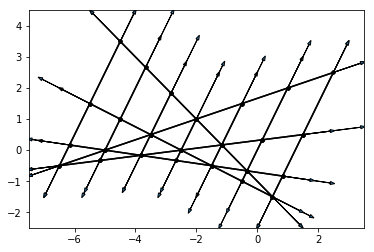

'401235,401253,401523,405123,540123,450123,042135,042153,024135,024153,054213,045213,042513,052413,025413,024513,502413,504213,204135,204153,204513,205413,250413,520413,410325,410532,410352,541032,451032,415032,143025,134025,143052,134052,314025,314052,314502,315402,351402,531402,513402,514302,134502,135402,153402,143502,145302,154302'

In [19]:
world = generate_neighborhoods_with_nearness(sample, show_plot=True)
",".join("".join(str(i) for i in land[1]) for land in world)

[(2, 2), (-1, -3), (-1, -1)]
[(3.0, 5.0, 1.0), (3.0, 3.0, -3.0), (0.0, -2.0, -4.0)]


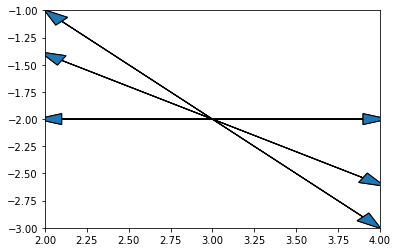

Generating the neighborhoods for [(2, 2), (-1, -3), (-1, -1)] took 0:00:00.117189 seconds.
[(2, 1), (1, 3), (1, -2), (-1, -2)]
[(1.0, -2.0, 2.5), (1.0, 3.0, -0.0), (3.0, 3.0, -0.0), (0.0, 5.0, -2.5), (2.0, 5.0, -2.5), (2.0, 0.0, -0.0)]


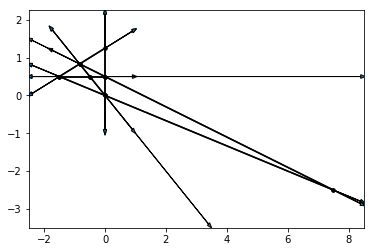

Generating the neighborhoods for [(2, 1), (1, 3), (1, -2), (-1, -2)] took 0:00:00.122288 seconds.
[(-4, 2), (-1, 2), (3, -1), (-3, 5), (3, 5)]
[(-3.0, 0.0, -7.5), (-7.0, 3.0, -5.0), (-1.0, -3.0, 7.0), (-7.0, -3.0, 7.0), (-4.0, 3.0, 2.5), (2.0, -3.0, 14.5), (-4.0, -3.0, 14.5), (6.0, -6.0, 12.0), (0.0, -6.0, 12.0), (-6.0, 0.0, -0.0)]


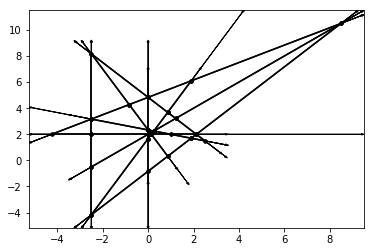

Generating the neighborhoods for [(-4, 2), (-1, 2), (3, -1), (-3, 5), (3, 5)] took 0:00:00.218537 seconds.
[(-3, 6), (-1, -4), (-3, -5), (6, 1), (4, 4), (-5, -6)]
[(-2.0, 10.0, -14.0), (0.0, 11.0, -5.5), (-9.0, 5.0, -4.0), (-7.0, 2.0, -6.5), (2.0, 12.0, 8.0), (2.0, 1.0, 8.5), (-7.0, -5.0, 10.0), (-5.0, -8.0, 7.5), (4.0, 2.0, 22.0), (-9.0, -6.0, 1.5), (-7.0, -9.0, -1.0), (2.0, 1.0, 13.5), (2.0, -3.0, -2.5), (11.0, 7.0, 12.0), (9.0, 10.0, 14.5)]
Error! Some neighborhoods not convex after intersecting [(-7.0, -5.0, 10.0), (-2.0, -1.0, -13.5), (7.0, 9.0, 1.0)] with (9.0, 10.0, 14.5):
[False, True]
Error! Some neighborhoods not convex after intersecting [(2.0, 1.0, 13.5), (-7.0, -9.0, -1.0), (-4.0, -2.0, -22.0), (5.0, 8.0, -7.5)] with (9.0, 10.0, 14.5):
[False, False]


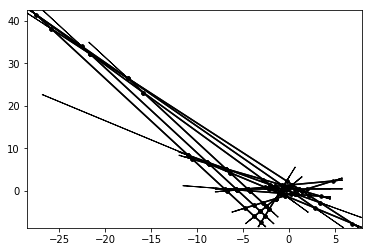

Generating the neighborhoods for [(-3, 6), (-1, -4), (-3, -5), (6, 1), (4, 4), (-5, -6)] took 0:00:00.392956 seconds.
[(-7, 0), (-4, -5), (-4, -7), (3, 3), (7, -2), (-4, 2), (-2, 2)]
[(-3.0, 5.0, -4.0), (-3.0, 7.0, 8.0), (-10.0, -3.0, -15.5), (-14.0, 2.0, 2.0), (-3.0, -2.0, -14.5), (-5.0, -2.0, -20.5), (0.0, 2.0, 12.0), (-7.0, -8.0, -11.5), (-11.0, -3.0, 6.0), (-2.0, -7.0, -16.5), (-7.0, -10.0, -23.5), (-11.0, -5.0, -6.0), (-2.0, -9.0, -28.5), (-4.0, 5.0, 17.5), (7.0, 1.0, 1.0), (5.0, 1.0, -5.0), (11.0, -4.0, -16.5), (9.0, -4.0, -22.5), (-2.0, 0.0, -6.0)]


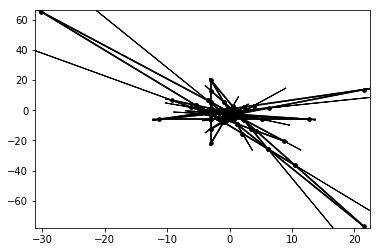

Generating the neighborhoods for [(-7, 0), (-4, -5), (-4, -7), (3, 3), (7, -2), (-4, 2), (-2, 2)] took 0:00:00.795587 seconds.


[(3, '0:00:00.117189'),
 (4, '0:00:00.122288'),
 (5, '0:00:00.218537'),
 (6, '0:00:00.392956'),
 (7, '0:00:00.795587')]

In [10]:
from datetime import datetime

def test(n, show_plot=False):
    sample = []
    while(len(set(list(sample)))<n):
        sample = [(randint(-n, n + 1), randint(-n, n + 1)) for i in range(n)]
    print(sample)
    t_start = datetime.now()
    walls_with = generate_walls_with_samples(sample)
    walls = generate_rival_dict(walls_with).keys()
    print(list(walls))
    world = generate_neighborhoods_from_walls(walls, show_plot=show_plot)
    t_elapsed = datetime.now() - t_start
    return (sample, t_elapsed)

samples = []
times = []
max_n = 7
for n in range(3, max_n + 1):
    s,t = test(n, show_plot=True)
    samples.append(s)
    times.append(str(t))
    print(f"Generating the neighborhoods for {s} took {t} seconds.")
list(zip(range(3, max_n + 1), times))

In [11]:
#The following are ad-hoc code tests

In [12]:
def test_split(bounded, bounds, line):
    nghbrhd = neighborhood(bounded=bounded, bounds=bounds)
    nghbrhd.plot()
    print(f"bounds: {nghbrhd.bounds}")
    print(f"corners: {nghbrhd.corners}")
    print(f"intersection with {line}: {nghbrhd.line_intersects(line)}")
    print(f"nghbrhd is convex: {nghbrhd.is_convex()}")
    split = nghbrhd.split_by_line(line)
    if split:
        for newbrhd in split:
            newbrhd.plot()
            print(newbrhd.bounded, newbrhd.bounds, newbrhd.corners, newbrhd.is_convex())
    else:
        print(f"{line} doesn't cut through nghbrhd.")

[(-3.0, -5.0, -7.0), (-1.0, 2.0, 5.5), (-5.0, -5.0, -5.0), (-6.0, -5.0, -2.5), (2.0, 7.0, 12.5), (-2.0, 0.0, 2.0), (-3.0, 0.0, 4.5), (-4.0, -7.0, -10.5), (-5.0, -7.0, -8.0), (-1.0, 0.0, 2.5)]
Building (-3.0, -5.0, -7.0) now...
[] [] (-3.0, -5.0, -7.0)
After dealing with wall (-3.0, -5.0, -7.0), there are 2 neighborhoods.
Building (-1.0, 2.0, 5.5) now...
[(-3.0, -5.0, -7.0)] [] (-1.0, 2.0, 5.5)
[(3.0, 5.0, 7.0)] [] (-1.0, 2.0, 5.5)
After dealing with wall (-1.0, 2.0, 5.5), there are 4 neighborhoods.
Building (-5.0, -5.0, -5.0) now...
[(-3.0, -5.0, -7.0), (-1.0, 2.0, 5.5)] [(1.2272727272727273, -2.1363636363636362)] (-5.0, -5.0, -5.0)
[(1.0, -2.0, -5.5), (-3.0, -5.0, -7.0)] [(1.2272727272727273, -2.1363636363636362)] (-5.0, -5.0, -5.0)
[(3.0, 5.0, 7.0), (-1.0, 2.0, 5.5)] [(1.2272727272727273, -2.1363636363636362)] (-5.0, -5.0, -5.0)
[(1.0, -2.0, -5.5), (3.0, 5.0, 7.0)] [(1.2272727272727273, -2.1363636363636362)] (-5.0, -5.0, -5.0)
After dealing with wall (-5.0, -5.0, -5.0), there are 7 n

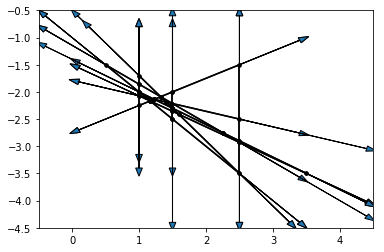

In [21]:
#sample = [(-3, -3), (0, 2), (-2, -5), (2, 2), (3, 2)]

walls_with = generate_walls_with_samples(sample)
walls = generate_rival_dict(walls_with).keys()
print(list(walls))
world = generate_neighborhoods_from_walls(walls, show_plot=True, debug=True)

[(1, -1, 1), (-2, -1, 7), (1, 2, -5)]


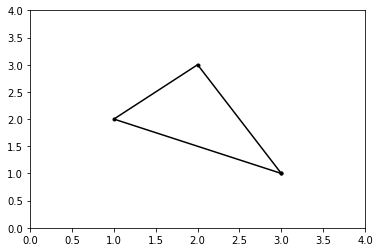

{(1.0, 2.0): [0, 2], (2.5, 2.0): [1]}


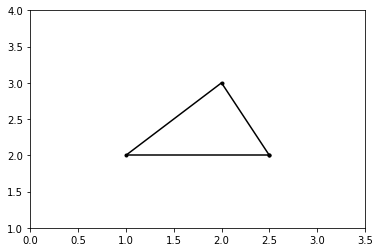

[(1, -1, 1), (-2, -1, 7), (0, 1, -2)] [(2.0, 3.0), (2.5, 2.0), (1.0, 2.0)] True


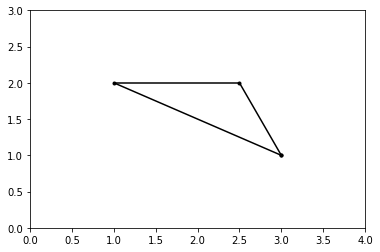

[(0, -1, 2), (-2, -1, 7), (1, 2, -5)] [(2.5, 2.0), (3.0, 1.0), (1.0, 2.0)] True


In [14]:
test1 = neighborhood(bounded=True, bounds=[], corners=[(2,3), (3,1), (1,2)])
print(test1.bounds)
test1.plot()
#print(test1.is_convex())
#print(test1.window())
#print(test1.line_hits_window((1,1,-5),1))
#print(test1.line_intersects((1,1,-5)))
#print(test1.line_intersects((1,1,-5.1)))
print(test1.line_intersects((0,1,-2)))
A,B = test1.split_by_line((0,1,-2))
A.plot()
print(A.bounds, A.corners, A.is_convex())
B.plot()
print(B.bounds, B.corners, B.is_convex())

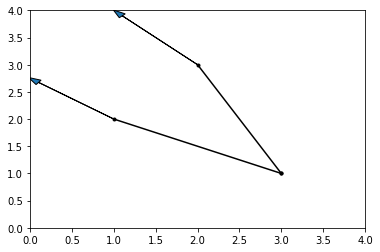

bounds: [(-1, -1, 5), (-2, -1, 7), (1, 2, -5), (3, 4, -11)]
corners: [(2.0, 3.0), (3.0, 1.0), (1.0, 2.0)]
intersection with (1, 1, -5): {(2.0, 3.0): [1], 0: []}
nghbrhd is convex: True


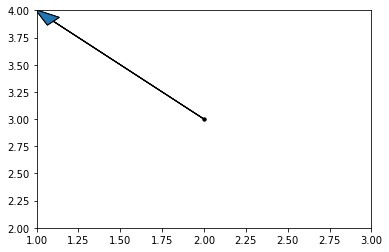

False [(-1, -1, 5), (-2, -1, 7), (-1, -1, 5)] [(2.0, 3.0), (2.0, 3.0)] True


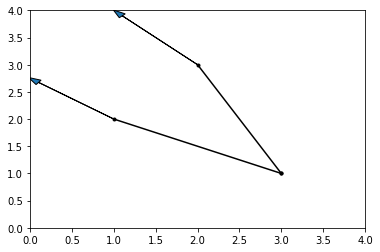

False [(1, 1, -5), (-2, -1, 7), (1, 2, -5), (3, 4, -11)] [(2.0, 3.0), (3.0, 1.0), (1.0, 2.0)] False


In [15]:
b2a = [(-1,-1,5),(-2,-1,7),(1,2,-5),(3,4,-11)]
b2b = [(3,4,-11),(1,2,-5),(-2,-1,7),(-1,-1,5)]
#test2 = neighborhood(bounded=False, bounds=b2a)
#print(test2.line_hits_window((1,1,-5),1))
test_split(False, b2a, (1,1,-5))
#test_split(False, b2a, (1,1,-5.1))
#test_split(False, b2a, (1,1,-4.9))
#test_split(False, b2a, (1,1,-4))
#test_split(False, b2a, (1,-1,0))

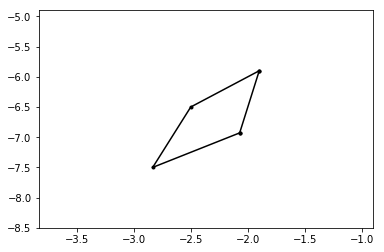

bounds: [(6.0, -2.0, 2.0), (1.0, -1.0, -4.0), (-6.0, 1.0, -5.5), (-3.0, 4.0, 21.5)]
corners: [(-2.5, -6.5), (-1.9, -5.9), (-2.0714285714285716, -6.928571428571429), (-2.8333333333333335, -7.5)]
intersection with (7.0, -2.0, 1.5): {(-1.9, -5.9): [1, 2], (-2.227272727272727, -7.045454545454546): [3]}
nghbrhd is convex: True


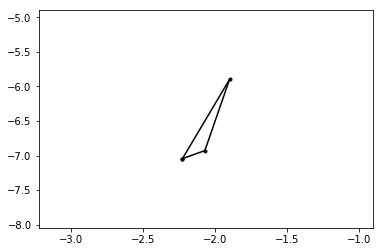

True [(-6.0, 1.0, -5.5), (-3.0, 4.0, 21.5), (7.0, -2.0, 1.5)] [(-2.0714285714285716, -6.928571428571429), (-2.227272727272727, -7.045454545454546), (-1.9, -5.9)] True


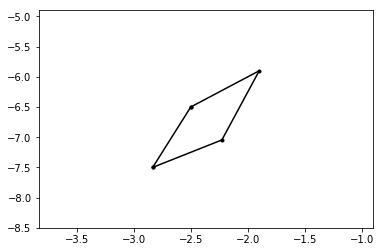

True [(-7.0, 2.0, -1.5), (-3.0, 4.0, 21.5), (6.0, -2.0, 2.0), (1.0, -1.0, -4.0)] [(-2.227272727272727, -7.045454545454546), (-2.8333333333333335, -7.5), (-2.5, -6.5), (-1.9, -5.9)] True


In [34]:
#test_split(False, [(3.0, 6.0, 7.5), (-2.0, 1.0, -2.5)], (2.0, -1.0, 12.5))

#[(4.0, -2.0, 10.0), (3.0, 6.0, 7.5), (-2.0, 1.0, -2.5)] [(-2.5, 0.0), (-1.5, -0.5)] (-1.0, 8.0, -2.5)
#test_split(False, [(4.0, -2.0, 10.0), (3.0, 6.0, 7.5), (-2.0, 1.0, -2.5)], line = (-1.0, 8.0, -2.5))

#[(-4.0, 2.0, -10.0), (3.0, 6.0, 7.5), (6.0, -3.0, 22.5)] [(-2.5, -0.0), (-3.5, 0.5)] (-1.0, 8.0, -2.5)
#test_split(False, [(-4.0, 2.0, -10.0), (3.0, 6.0, 7.5), (6.0, -3.0, 22.5)], (-1.0, 8.0, -2.5))

#[(1.0, -8.0, 2.5), (2.0, -1.0, 2.5), (3.0, 6.0, 7.5), (-2.0, 1.0, 2.5)] [(1.5, 0.5), (-1.1666666666666667, 0.16666666666666666), (-1.5, -0.5), (0.5, -1.5)] (4.0, -2.0, -0.0)
#test_split(True, [(1.0, -8.0, 2.5), (2.0, -1.0, 2.5), (3.0, 6.0, 7.5), (-2.0, 1.0, 2.5)], (4.0, -2.0, -0.0))

#[(10.0, 6.0, 4.0), (4.0, -3.0, 5.5), (-12.0, 2.0, 6.0), (1.0, 10.0, 1.5)] with (-6.0, -9.0, 1.5)
#test_split(False, [(10.0, 6.0, 4.0), (4.0, -3.0, 5.5), (-12.0, 2.0, 6.0), (1.0, 10.0, 1.5)], (-6.0, -9.0, 1.5))

#Above here are solved.

#FAILURE OF FLOATING POINT ARITHMETIC
#[(-3.0, -5.0, -7.0), (-2.0, 0.0, 2.0), (2.0, 7.0, 12.5)] [(1.0, -2.0), (1.0, -2.0714285714285716)] (-4.0, -7.0, -10.5)
#test_split(False, [(-3.0, -5.0, -7.0), (-2.0, 0.0, 2.0), (2.0, 7.0, 12.5)], (-4.0, -7.0, -10.5))

#Below here are unsolved.

#[(-3.0, 1.0, 16.0), (-6.0, -1.0, -2.5), (8.0, -7.0, -12.5), (3.0, -2.0, -3.5)] with (-3.0, -3.0, -6.0)
#test_split(False, [(-3.0, 1.0, 16.0), (-6.0, -1.0, -2.5), (8.0, -7.0, -12.5), (3.0, -2.0, -3.5)], (-3.0, -3.0, -6.0))
#test_split(False, [(-3.0, 1.0, 16.0), (-6.0, -1.0, -2.5), (8.0, -7.0, -12.5)], (3.0, -2.0, -3.5))
#test_split(False, [(-3.0, 1.0, 16.0), (-6.0, -1.0, -2.5), (3.0, -2.0, -3.5)], (8.0, -7.0, -12.5))

#[(6.0, -2.0, 2.0), (1.0, -1.0, -4.0), (-6.0, 1.0, -5.5), (-3.0, 4.0, 21.5)] with (7.0, -2.0, 1.5)
test_split(True, [(6.0, -2.0, 2.0), (1.0, -1.0, -4.0), (-6.0, 1.0, -5.5), (-3.0, 4.0, 21.5)], (7.0, -2.0, 1.5))

#Error! Some neighborhoods not convex after intersecting [(-7.0, -5.0, 10.0), (-2.0, -1.0, -13.5), (7.0, 9.0, 1.0)] with (9.0, 10.0, 14.5):


#Error! Some neighborhoods not convex after intersecting [(2.0, 1.0, 13.5), (-7.0, -9.0, -1.0), (-4.0, -2.0, -22.0), (5.0, 8.0, -7.5)] with (9.0, 10.0, 14.5):

In [25]:
intersect_of_lines((-6.0, -1.0, -2.5), (3.0, -2.0, -3.5))

(-0.1, -1.9)

In [17]:
# The following are abandoned incomplete code

In [18]:
#This abandoned approach was intended to keep a record of the subdivisions of each wall,
# and label which neighborhoods each segment belonged to.

def find_joint(oldw,neww):
    a,b,c = oldw
    d,e,f = neww
    denom = a*e - b*d
    if denom==0:
        #print(f"The walls {oldw} and {neww} are parallel.")
        return False
    joint = [(d*c - a*f)/denom, (b*f - c*e)/denom]
    return joint

def locate_joint(h, joint):
    L = len(joints[h])
    for loc in range(L):
        oldx, oldy = joints[h][loc]
        if joint[0]<oldx:
            return loc - 0.5
        elif joint[0]==oldx:
            if joint[1]<oldy:
                return loc - 0.5
            elif joint[1]==oldy:
                return loc
    return L - 0.5

def insert_joint(h, loc, joint):
    if isinstance(loc, int):
        #The joint already existed
        #ToDo: Update regions
        pass
    else:
        #The joint needs to be added
        joints[h].insert(ceil(loc), joint)
        #ToDo: Update regions

#Assuming wall h has been divided and wall k is being added, so h<k
def add_joint(h,k):
    if h<0 or k<=h or len(walls)<=k:
        #print(f"Expecting 0<=h<k<len(walls)")
        return False
    
    old = walls[h]
    new = walls[k]
    
    joint = find_joint(old[0], new[0])
    #print(joint)
    if not joint:
        #ToDo: Check if same line.
        return False
    
    joints[k].append(joint)
    h_loc = locate_joint(h, joint)
    insert_joint(h, h_loc, joint)
    k_loc = locate_joint(k, joint)
    insert_joint(k, k_loc, joint)


In [19]:
m = len(walls)
joints = [[] for i in range(m)]
regions = [[] for i in range(m)]
regions[0].append(walls[0][1])
for k in range(m):
    for h in range(k): 
        add_joint(h,k)
#print(joints)
for jnts in joints:
    plt.scatter(*zip(*jnts))
plt.show()

TypeError: 'dict_keys' object does not support indexing

In [ ]:
# This abondoned code was to make bounds that also help the pairs of points they divided, 
#  but that seems like a lot to carry around.
class bound:
    def __init__(self, triple, rivals = []):
        try: 
            self.a,self.b,self.c=triple
        except ValueError:
            print(f"The bound requires a triple (a,b,c) for ax+by+c>0, but you provided {triple}.")
        self.rivals = rivals
    